# Wetland water depth validation<img align="right" src="../../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI` and `DEA Sandbox` environment 
* **Products used:** 
* **Special requirements:** 
* **Prerequisites:** This notebook assumes you have previously run the [WetlandWaterDepthAnalyses.ipynb](./WetlandWaterDepthAnalyses.ipynb) and [WetlandWaterDepthOutputs.ipynb](./CEWODeliverables.ipynb) notebooks and saved out the netCDF files containing all the variables at the end of the notebooks.

## Background


## Description


<a id='GettingStarted'></a>
## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import sys
import glob
import itertools
import xarray as xr
import numpy as np
import pandas as pd
from rasterio import features, transform
import geopandas as gpd
from shapely.geometry import shape as shapelyshape, Point as shapelypoint

import pickle
import warnings
warnings.simplefilter("ignore")

<a id='AnalysisParameters'></a>
## Analysis parameters

* `AnalysisLocation`: A string descriptor of the analysis region used to label graphs.
* `OutSaveLocation`: A string folder structure for the location of files written out by the [WetlandWaterDepthAnalyses.ipynb](./WetlandWaterDepthAnalyses.ipynb) notebook, and this notebook. It makes use of the `AnalysisLocation` string to generate the filepath.

### Files to analyse
* `DatasetToLoad`: The filename of the netCDF written out by the [first notebook](./WetlandWaterDepthAnalyses.ipynb) to read in here. Note that this file must have been written out by the first notebook, as we assume the variables created in that notebook exist here. If you try to read in something else, this code will fail.

!ogr2ogr -t_srs EPSG:3577 InputData/Gwydir/GwydirOldDromanaRamsar3577.shp InputData/Gwydir/GwydirOldDromanaRamsar.shp

In [316]:
# Note, if your `AnalysisLocation` contains special characters other than spaces, you will
# need to modify the `replace` function used to generate the output file names.
AnalysisLocation = 'Gwydir - Old Dromana'
OutSaveLocation = f'OutputData/Gwydir/'

RamsarBoundaryFile = f'InputData/Gwydir/{AnalysisLocation.replace(" ", "").replace("-", "")}Ramsar3577.shp'
WetlandWaterDepthsFileName = f'{OutSaveLocation}WetlandWaterDepths{AnalysisLocation.replace(" ", "")}.nc'
ValidationDatasetAll = 'ValidationData/FrogSurveyWaterDepthDataMacMarshesGwydirThomas.csv'
ValidationDatasetLocationsCSV = 'ValidationData/FrogSurveyWaterDepthDataMacMarshesGwydirThomasLocations.csv'

# Outfiles
ValidationLSPlots = f'ValidationData/OutputData/{AnalysisLocation.replace(" ", "").replace("-", "")}'

<a id='LoadData'></a>
## Load in our pre-analysed datasets

In [3]:
WetlandDepths = xr.open_dataset(WetlandWaterDepthsFileName)

In [4]:
WetlandDepths

<xarray.Dataset>
Dimensions:  (time: 625, x: 791, y: 644)
Coordinates:
  * time     (time) datetime64[ns] 1986-08-21T23:16:16.640546 ... 2019-08-08T23:42:21.260121040
  * y        (y) float64 -3.302e+06 -3.302e+06 ... -3.305e+06 -3.305e+06
  * x        (x) float64 1.656e+06 1.656e+06 1.656e+06 ... 1.66e+06 1.66e+06
Data variables:
    DEM      (time, y, x) float32 ...

### Read in the Ramsar boundary shapefile

In [5]:
RamsarBoundary = gpd.read_file(RamsarBoundaryFile)
RamsarBoundary = RamsarBoundary.to_crs(crs='EPSG:3577')

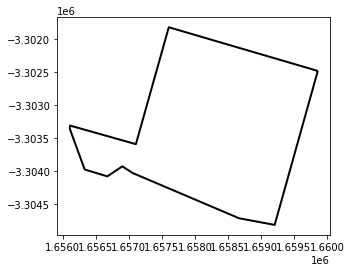

In [6]:
RamsarBoundary.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2);

### Load in the validation data

The validation dataset is a csv. We want to import it and turn it into a geopandas dataframe so that we can compare the locations of the validation datasets against our wetland.

In [7]:
ValidationDataLocations = pd.read_csv(ValidationDatasetLocationsCSV)

In [8]:
ValidationDataLocationsgdf = gpd.GeoDataFrame(
    ValidationDataLocations.drop(['Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'], axis=1),
    crs={'init': 'epsg:4326'},
    geometry=[shapelypoint(xy) for xy in zip(ValidationDataLocations.Long, ValidationDataLocations.Lat)])

ValidationDataLocationsgdf = ValidationDataLocationsgdf.to_crs(crs='EPSG:3577')

In [9]:
ValidationDataLocationsgdf.head()

,Region,sitecode,ManagementUnit,SiteName,SiteType,Lat,Long,geometry
0,Gwydir,ALLA,Lower Gwydir,Allambie Bridge,River,-29.344839,149.430810,POINT (1667864.439 -3303815.951)
1,Gwydir,BNNB,Central Gingham,Bunnor Bird Hide,Wetland,-29.276094,149.381810,POINT (1664250.619 -3295538.610)
2,Gwydir,BNNF,Central Gingham,Bunnor floodplain,Floodplain,-29.270417,149.350633,POINT (1661370.145 -3294502.113)
3,Gwydir,BOYW,Lower Gingham,Boyanga Waterhole,Waterhole & wetland,-29.209144,149.243080,POINT (1652059.128 -3286298.188)
4,Macquarie Marshes,BUCK4,South Marsh,Bill Johnson Causeway,marsh,-31.039000,147.495790,POINT (1460702.331 -3468445.857)


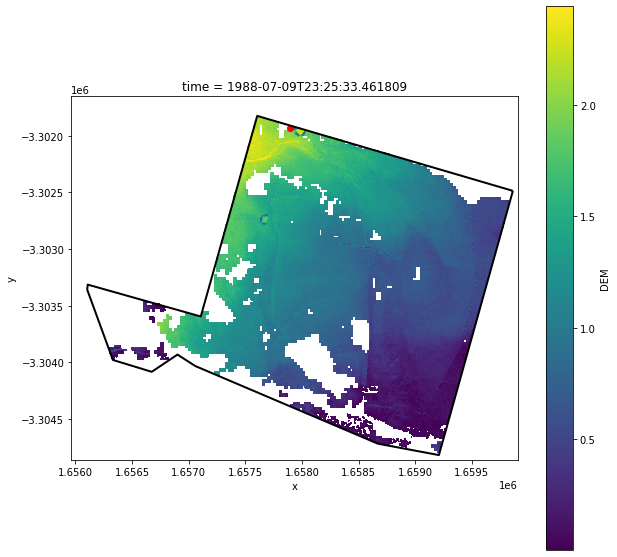

In [10]:
fig, ax = plt.subplots(figsize=([10,10]));
RamsarBoundary.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2, ax=ax);
xmin,xmax = ax.get_xlim();
ymin,ymax = ax.get_ylim();
ax.set_xlim([xmin,xmax]);
ax.set_ylim([ymin,ymax]);
WetlandDepths['DEM'].isel({'time':10}).plot()
ValidationDataLocationsgdf.plot(ax=ax, color='r');

In [11]:
ValidationData = pd.read_csv(ValidationDatasetAll)

In [12]:
ValidationDatagdf = gpd.GeoDataFrame(
    ValidationData,
    crs={'init': 'epsg:4326'},
    geometry=[shapelypoint(xy) for xy in zip(ValidationData.Long, ValidationData.Lat)])

ValidationDatagdf = ValidationDatagdf.to_crs(crs='EPSG:3577')
ValidationDatagdf['visitdate'] = pd.to_datetime(ValidationDatagdf['visitdate'])

## Find where the validation data intersect with our wetland polygon

In [13]:
# Check whether each site intersects with the Ramsar polygon
ValidationIntersections = []
for p in ValidationDataLocationsgdf.iterrows():
    if RamsarBoundary.intersects(p[1]['geometry']).bool():
        ValidationIntersections.append(p)

### Check whether we actually have any intersecting data and extract the timeseries

Yes, we have validation data for our Ramsar polygon


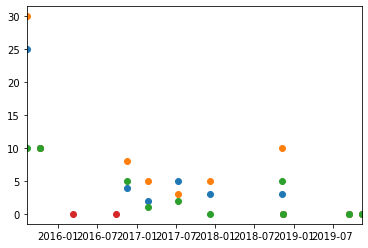

In [107]:
if ValidationIntersections:
    IntersectingValidationData ={}
    print('Yes, we have validation data for our Ramsar polygon')
    for item in ValidationIntersections:
        PointData = ValidationDatagdf.loc[ValidationDatagdf['sitecode'] == item[1]['sitecode']]
        IntersectingValidationData[item[1]['sitecode']] = PointData  
    for keys in IntersectingValidationData:
        Pointdf = IntersectingValidationData[keys]
        # create a mask where data has no-data
        NoDataMask = WetlandDepths.isnull().all()
        # mask out regions where there is no-data
        WetlandDepthsValid = WetlandDepths.where(~NoDataMask)
        WetlandDepthPoint = WetlandDepths.sel({'x':Pointdf['geometry'].iloc[0].x, 'y':Pointdf['geometry'].iloc[0].y}, method ='nearest')
        plt.plot(Pointdf['visitdate'], Pointdf['WaterDepth_replicate1cm'], 'o',
                 Pointdf['visitdate'], Pointdf['WaterDepth_replicate2cm'], 'o',
                 Pointdf['visitdate'], Pointdf['WaterDepth_replicate3cm'], 'o'); 
        plt.plot(WetlandDepthPoint.time, WetlandDepthPoint.DEM, 'o')
        plt.xlim([Pointdf['visitdate'].min(), Pointdf['visitdate'].max()])
else:
    print('No, the validation data doesn\'t overlap')

In [85]:
NotNan = np.isfinite(WetlandDepths).sum(dim='time')
NotNanNotZero = NotNan['DEM'] > 0
pct = np.nanpercentile(NotNan.where(NotNanNotZero).DEM, 10)
PctMask = NotNan > pct

In [117]:
FindCloseX = np.abs((WetlandDepths.x- Pointdf['geometry'].iloc[0].x))
FindCloseY = np.abs((WetlandDepths.y - Pointdf['geometry'].iloc[0].y))
CombinedClosest = np.sort(FindCloseX + FindCloseY)

In [93]:
WetlandDepthsValid

<xarray.Dataset>
Dimensions:  (time: 625, x: 791, y: 644)
Coordinates:
  * time     (time) datetime64[ns] 1986-08-21T23:16:16.640546 ... 2019-08-08T23:42:21.260121040
  * y        (y) float64 -3.302e+06 -3.302e+06 ... -3.305e+06 -3.305e+06
  * x        (x) float64 1.656e+06 1.656e+06 1.656e+06 ... 1.66e+06 1.66e+06
Data variables:
    DEM      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan

In [126]:
ObsDate = Pointdf['visitdate'].iloc[0]

In [317]:
if ValidationIntersections:
    IntersectingValidationData ={}
    print('Yes, we have validation data for our Ramsar polygon')
    for item in ValidationIntersections:
        PointData = ValidationDatagdf.loc[ValidationDatagdf['sitecode'] == item[1]['sitecode']]
        IntersectingValidationData[item[1]['sitecode']] = PointData
        for keys in IntersectingValidationData:
            Pointdf = IntersectingValidationData[keys]
            for Row in Pointdf.iterrows():
                ObsDate = Row[1]['visitdate']

                ClosestLS = WetlandDepths.sel({'time': ObsDate}, method='nearest')
                fig, ax = plt.subplots(figsize=([8,8]));
                fig.subplots_adjust(right=0.8);
                cbar_ax = fig.add_axes([0.85, 0.2, 0.04, 0.6]);
                RamsarBoundary.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2, ax=ax);
                h = ClosestLS.DEM.plot(cmap='viridis', ax=ax, cbar_ax=cbar_ax, vmin=0, vmax=5);
                ax.scatter(Row[1]['geometry'].x, Row[1]['geometry'].y, c = Row[1]['WaterDepth_replicate1cm'], 
                           cmap=h.cmap, s=100, edgecolors='r', vmin=0, vmax=5);
                ax.ticklabel_format(useOffset=False, style='plain');
                cbar_ax.set_ylabel('Wetland inundation (m)');
                ax.set_title(f'Field obs date: {ObsDate.strftime("%Y-%m-%d")}, Landsat date: {ClosestLS.time.dt.strftime("%Y-%m-%d").item()}');
                fig.savefig(f'{ValidationLSPlots}_{keys}_{ObsDate.strftime("%Y-%m-%d")}.jpg', 
                            bbox_inches='tight');
                fig.clear();    

Yes, we have validation data for our Ramsar polygon


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

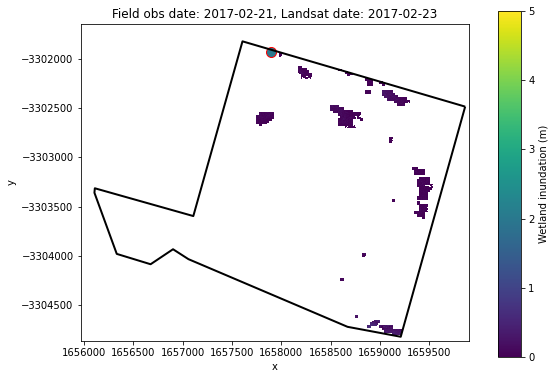

In [315]:
fig, ax = plt.subplots(figsize=([8,8]));
fig.subplots_adjust(right=0.8);
cbar_ax = fig.add_axes([0.85, 0.2, 0.04, 0.6]);
RamsarBoundary.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2, ax=ax);
h = ClosestLS.DEM.plot(cmap='viridis', ax=ax, cbar_ax=cbar_ax, vmin=0, vmax=5);
ax.scatter(Row[1]['geometry'].x, Row[1]['geometry'].y, c = Row[1]['WaterDepth_replicate1cm'], 
           cmap=h.cmap, s=100, edgecolors='r', vmin=0, vmax=5);
ax.ticklabel_format(useOffset=False, style='plain');
cbar_ax.set_ylabel('Wetland inundation (m)');
ax.set_title(f'Field obs date: {ObsDate.strftime("%Y-%m-%d")}, Landsat date: {ClosestLS.time.dt.strftime("%Y-%m-%d").item()}');

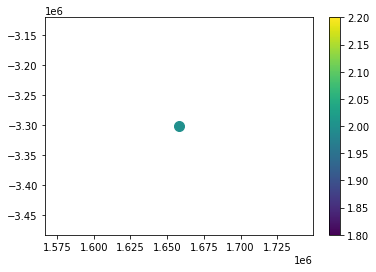

In [308]:
plt.scatter(Row[1]['geometry'].x, Row[1]['geometry'].y, c = Row[1]['WaterDepth_replicate1cm'], cmap=h.cmap, s=100);
plt.colorbar()

In [310]:
c

2.0